In [66]:
%%bash 
jupyter nbconvert --to html Training_Network_to_Idenfitying_HandPicked_Classes.ipynb && mv Training_Network_to_Idenfitying_HandPicked_Classes.html ../notebook_htmls/Training_Network_to_Idenfitying_HandPicked_Classes_v1.html


[NbConvertApp] Converting notebook Training_Network_to_Idenfitying_HandPicked_Classes.ipynb to html
[NbConvertApp] Writing 640614 bytes to Training_Network_to_Idenfitying_HandPicked_Classes.html



# Overview: Training Network for Useful Features. 

Input: 
- set of images that match along some interpretable feature. (e.g. striped dress)
- a whole bunch of images that don't match
- set of image features 

Output: 
- estimates and saves out weights for those neural network features to predict the interpreable feature class
    - regularized logisitic regression or other classifiers. 


In [3]:
import sys 
import os
sys.path.append(os.getcwd()+'/../')

# sklearn
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import permutation_test_score

# other
import numpy as np
import glob
import pandas as pd
import ntpath

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
    for i in range(len(y_hat)): 
        if (y_hat[i]==1) and (y_actual[i]!=y_hat[i]):
           FP += 1
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==0:
           TN += 1
    for i in range(len(y_hat)): 
        if (y_hat[i]==0) and (y_actual[i]!=y_hat[i]):
           FN += 1

    return(TP, FP, TN, FN)

# Predicting Own Labels from Selected Images

- within a folder (find class 1, class 0). 
- (split into test train)
- get matrix of img X features X class
- fit logistic regression (or other classifier) 
- assess test set-fit. 
- html (sample images used to define class; top and bottom predictions from test-set. 



In [4]:
# image folder 
target_img_folder ='../data_img_classes/class_red_pink/'


In [5]:

# all the image folders
non_target_img_folders = ['../original_img/']

target_img_paths=glob.glob(target_img_folder+'*')
target_img_paths_stemless = [ntpath.basename(t) for t in target_img_paths]
non_target_img_paths =[]
for non_target_folder in non_target_img_folders:
    for img_path in glob.glob(non_target_folder+'*'):
        if ntpath.basename(img_path) not in target_img_paths_stemless: # remove targets from non-target list
            non_target_img_paths.append(img_path)

# create data frame with image name and label
img_paths = np.append(target_img_paths,non_target_img_paths)
labels = np.append(np.ones(len(target_img_paths)),np.zeros(len(non_target_img_paths)))
df = pd.DataFrame(data=np.vstack((img_paths,labels)).T,columns=['img_path','label']) 
df['img_name'] = df['img_path'].apply(lambda x: ntpath.basename(x)) # add image name
df['label'] = df['label'].apply(lambda x: float(x)) # add label 


In [7]:
df.head()

,img_path,label,img_name
0,../data_img_classes/class_red_pink/ANGEL-62140...,1.0,ANGEL-6214020T0805-5.jpg
1,../data_img_classes/class_red_pink/ANGEL-62140...,1.0,ANGEL-621402220501-5.jpg
2,../data_img_classes/class_red_pink/ANGELCITIZ-...,1.0,ANGELCITIZ-621308290602-5.jpg
3,../data_img_classes/class_red_pink/Bai-B520N01...,1.0,Bai-B520N015-5.jpg
4,../data_img_classes/class_red_pink/BAIYI-B1008...,1.0,BAIYI-B1008N289-5.jpg


In [ ]:
# load up features per image
img_feature_df = pd.read_csv('../data_nn_features/img_features_all.csv',index_col=0)
img_feature_df.head()


In [13]:
# get target and non-target lists

def create_image_class_dataframe(target_img_folder):


    # create feature matrix out of loaded up features. 
    for i,row in df.iterrows():
        features = img_feature_df.loc[img_feature_df.img_name==row['img_name'],'nn_features'].as_matrix()[0].replace(']','').replace('[','').split(',')
        features = [np.float(f) for f in features]
        lab = row['img_name']
        if i==0:
            X = features
            labs = lab
        else:
            X = np.vstack((X,features))
            labs = np.append(labs,lab)

    xcolumns = ['x'+str(i) for i in np.arange(X.shape[1])]
    X_df = pd.DataFrame(np.hstack((labs[:,np.newaxis],X)),columns=['img_name']+xcolumns)

    # merge together 
    df = df.merge(X_df,on='img_name')
    
    # make sure there is only one instance per image in dataframe
    lens = np.array([])
    for img_name in df.img_name.unique():
        lens = np.append(lens,len(df.loc[df.img_name==img_name]))


    assert len(np.unique(lens)[:])==1
    
    return(df)
    

In [14]:
# remove some non-targets to make dataset smaller #
# i_class0 = np.where(df.label==0.0)[0]
# i_class0_remove = np.random.choice(i_class0,int(np.round(len(i_class0)/1.1)))
# df_smaller = df.drop(i_class0_remove)
#df_smaller.to_csv('test.csv')

### Horizontal Striped Data

In [15]:
# image folder 
target_img_folder ='../data_img_classes/class_horiztonal_striped/'
df = create_image_class_dataframe(target_img_folder)
df.head()

,img_path,label,img_name,x0,x1,x2,x3,x4,x5,x6,...,x2038,x2039,x2040,x2041,x2042,x2043,x2044,x2045,x2046,x2047
0,../data_img_classes/class_horiztonal_striped/E...,1.0,EUROMODA-U125256-39-5.jpg,0.080648147,0.0092789298,0.0014473638,0.79745281,0.1980352,0.0092308726,1.1527375,...,0.010522826,0.52378851,0.0,4.1638546,0.0,0.0023334951,1.5376362,0.41636777,0.0,0.37979186
1,../data_img_classes/class_horiztonal_striped/E...,1.0,EUROMODA-U125267-79-5.jpg,0.012774257,1.0192471,0.13633534,0.7930606,0.41112542,0.0,1.4454148,...,0.36394235,0.0,0.035090849,2.28038,0.12486018,0.0,1.5214183,0.35948351,0.037030876,0.047698129
2,../data_img_classes/class_horiztonal_striped/E...,1.0,EUROMODA-U127278-03-5.jpg,0.2103394,0.44533923,0.23877689,2.1717458,0.040404715,0.0,0.19045945,...,2.9992921,0.0041331076,0.054148678,2.9987047,0.0011503234,0.0,0.84170794,0.56640506,0.079589754,0.015616337
3,../data_img_classes/class_horiztonal_striped/E...,1.0,EUROMODA-U127278-13-5.jpg,0.095383428,0.87436837,0.075488105,0.60814637,0.10280731,0.052728202,0.30020541,...,0.48274636,0.24174443,0.079249993,2.4447916,0.21308827,0.035023067,0.06211203,0.52482486,0.10131172,0.0
4,../data_img_classes/class_horiztonal_striped/E...,1.0,EUROMODAJ-U125406-09-5.jpg,0.49232581,0.055619191,0.043276276,2.4512403,0.21075039,0.0,0.2511763,...,0.89770401,0.12855974,0.0,2.7500679,0.44566065,0.0,1.6538981,3.4805861,0.05550551,1.0497173


target class


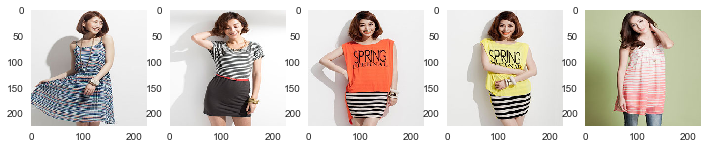

In [31]:
print('target class')
plt.figure(figsize=(12,3))
for i in range(5):
    img_path= df['img_path'][i]
    img = image.load_img(img_path, target_size=(224, 224))
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.grid(b=False)

In [35]:
xcolumns=['x'+str(i) for i in np.arange(2024)]
X = df.loc[:,xcolumns].as_matrix().astype('float')
y= df.loc[:,'label'].as_matrix().astype('float')
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y,stratify=y,test_size=.33)
print(' training shape {0} \n testing shape {1}').format(X_train.shape,X_test.shape)
print('\n target/non-target \n (train) {0}\{1} \n (test) {2}\{3}').format(y_train.sum(),(1-y_train).sum(),y_test.sum(),(1-y_test).sum())

 training shape (338, 2024) 
 testing shape (167, 2024)

 target/non-target 
 (train) 11.0\327.0 
 (test) 6.0\161.0


In [52]:
# classifiers 
C = 1.0
clf_LR = LogisticRegression(C=C, penalty='l1', tol=0.01)
clf_svm = sklearn.svm.SVC(C=C,kernel='linear')


In [53]:
clf_LR.fit(X_train, y_train)
clf_svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

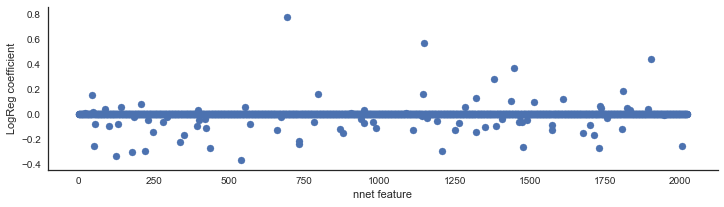

In [44]:
coef = clf_LR.coef_[0,:]
plt.figure(figsize=(12,3))
sns.set_style('white')
plt.scatter(np.arange(len(coef)),coef)
plt.xlabel('nnet feature')
plt.ylabel('LogReg coefficient')
sns.despine()

In [54]:
y_pred = clf_LR.predict(X_test)

(TP,FP,TN,FN) =perf_measure(y_test,y_pred)
print('TruePos:{0}\nFalsePos:{1}\nTrueNeg:{2}\nFalseNeg:{3}').format(TP,FP,TN,FN)

TruePos:1
FalsePos:0
TrueNeg:161
FalseNeg:5


In [46]:
y_pred = clf_svm.predict(X_test)

(TP,FP,TN,FN) =perf_measure(y_test,y_pred)
print('TruePos:{0}\nFalsePos:{1}\nTrueNeg:{2}\nFalseNeg:{3}').format(TP,FP,TN,FN)

TruePos:2
FalsePos:0
TrueNeg:161
FalseNeg:4


- neither the svm or the logistic reg is doing well

In [48]:
# from sklearn.model_selection import StratifiedKFold
# skf = StratifiedKFold(n_splits=5,shuffle=True)
# for train, test in skf.split(X, y):
#     #print("%s %s" % (train, test))
#     C=1.0
#     clf_LR = LogisticRegression(C=C, penalty='l1', tol=0.01)
#     clf_LR.fit(X[train], y[train])
#     y_pred = clf_LR.predict(X[test])
#     (TP,FP,TN,FN) =perf_measure(y[test],y_pred)
#     print('\nTruePos:{0}\nFalsePos:{1}\nTrueNeg:{2}\nFalseNeg:{3}').format(TP,FP,TN,FN)

In [49]:
clf_LR = LogisticRegression(C=C, penalty='l1', tol=0.01)
skf = StratifiedKFold(n_splits=5,shuffle=True)
score, permutation_scores, pvalue = permutation_test_score(
    clf_LR, X, y, scoring="accuracy", cv=skf, n_permutations=100)

In [56]:
#

0.00990099009901


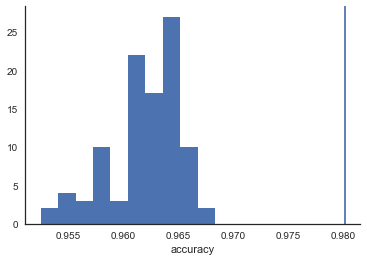

In [50]:
plt.hist(permutation_scores)
plt.axvline(score)
sns.despine()
plt.xlabel('accuracy')
print(pvalue)

- the accuracy achieved is above chance (as determined by permutation testing)

### Red / Pink Data

In [58]:
# image folder 
target_img_folder ='../data_img_classes/class_red_pink/'
df = create_image_class_dataframe(target_img_folder)
df.head()

,img_path,label,img_name,x0,x1,x2,x3,x4,x5,x6,...,x2038,x2039,x2040,x2041,x2042,x2043,x2044,x2045,x2046,x2047
0,../data_img_classes/class_red_pink/ANGEL-62140...,1.0,ANGEL-6214020T0805-5.jpg,0.27172932,0.54065263,1.2518882,0.71433866,0.0,0.223846,0.208391,...,3.1341801,0.078170836,0.19200282,1.3976613,0.01351728,0.0097718844,0.92253286,0.46201733,2.3602607,0.12272973
1,../data_img_classes/class_red_pink/ANGEL-62140...,1.0,ANGEL-621402220501-5.jpg,0.15732542,0.85577351,0.13256542,1.6754812,0.14064166,0.72851104,0.15100212,...,0.61663407,0.321567,0.13439243,1.693658,0.022544336,0.03912805,0.11787287,0.29207376,0.59155571,0.38405305
2,../data_img_classes/class_red_pink/ANGELCITIZ-...,1.0,ANGELCITIZ-621308290602-5.jpg,0.41256633,0.38114852,0.18842269,1.5292635,0.85203356,0.27785954,0.18870671,...,0.18259989,0.49224538,0.46193609,3.8138292,0.19726405,0.097800381,0.22442091,1.3731562,0.31209072,0.75006706
3,../data_img_classes/class_red_pink/Bai-B520N01...,1.0,Bai-B520N015-5.jpg,0.039242335,0.36203983,0.0042010327,0.37699968,0.46601561,0.0,0.46742466,...,0.15885612,0.13920899,0.16824563,3.6293392,0.10784438,0.0039167427,0.33787274,2.1860485,0.28497639,0.93075883
4,../data_img_classes/class_red_pink/BAIYI-B1008...,1.0,BAIYI-B1008N289-5.jpg,0.43477067,0.33263576,0.0,0.40581283,0.14094441,0.017958783,0.63126558,...,0.70636362,0.19716582,0.12621519,4.4085803,0.11626053,0.0,0.27553368,1.5186014,0.13309085,1.9339614


target class


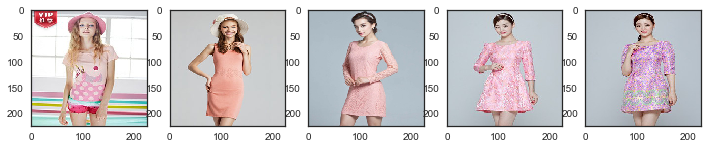

In [60]:
print('target class')
plt.figure(figsize=(12,3))
for i in range(5):
    img_path= df['img_path'][i+1]
    img = image.load_img(img_path, target_size=(224, 224))
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.grid(b=False)

In [62]:
# split data 
xcolumns=['x'+str(i) for i in np.arange(2024)]
X = df.loc[:,xcolumns].as_matrix().astype('float')
y= df.loc[:,'label'].as_matrix().astype('float')
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y,stratify=y,test_size=.33)
print(' training shape {0} \n testing shape {1}').format(X_train.shape,X_test.shape)
print('\n target/non-target \n (train) {0}\{1} \n (test) {2}\{3}').format(y_train.sum(),(1-y_train).sum(),y_test.sum(),(1-y_test).sum())



 training shape (338, 2024) 
 testing shape (167, 2024)

 target/non-target 
 (train) 41.0\297.0 
 (test) 21.0\146.0


In [63]:
# Train
clf_svm.fit(X_train, y_train)

# test 
y_pred = clf_svm.predict(X_test)
(TP,FP,TN,FN) =perf_measure(y_test,y_pred)
print('TruePos:{0}\nFalsePos:{1}\nTrueNeg:{2}\nFalseNeg:{3}').format(TP,FP,TN,FN)

TruePos:14
FalsePos:6
TrueNeg:140
FalseNeg:7


- classification performance is mucher better on this dataset

In [64]:
clf_LR = LogisticRegression(C=C, penalty='l1', tol=0.01)
skf = StratifiedKFold(n_splits=5,shuffle=True)
score, permutation_scores, pvalue = permutation_test_score(
    clf_LR, X, y, scoring="accuracy", cv=skf, n_permutations=100)

0.00990099009901


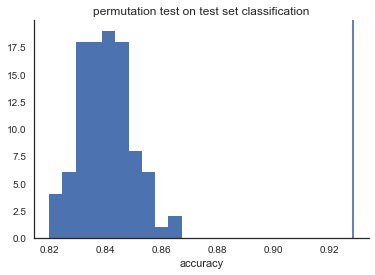

In [65]:
plt.hist(permutation_scores)
plt.axvline(score)
sns.despine()
plt.xlabel('accuracy')
plt.title('permutation test on test set classification')
print(pvalue)

In [1]:
%%bash 
jupyter nbconvert --to html Training_Network_to_Idenfitying_HandPicked_Classes.ipynb && mv Training_Network_to_Idenfitying_HandPicked_Classes.html ../notebook_htmls/Training_Network_to_Idenfitying_HandPicked_Classes_v2.html
cp Training_Network_to_Idenfitying_HandPicked_Classes.ipynb ../notebook_versions/Training_Network_to_Idenfitying_HandPicked_Classes_v2.ipynb




[NbConvertApp] Converting notebook Training_Network_to_Idenfitying_HandPicked_Classes.ipynb to html
[NbConvertApp] Writing 640629 bytes to Training_Network_to_Idenfitying_HandPicked_Classes.html
